<a href="https://colab.research.google.com/github/AlexandreAdam/Censai/blob/eager2.4/notebooks/train_raytracer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RayTracer

Uncomment the following block to start

In [1]:
!git clone https://github.com/AlexandreAdam/Censai.git
%cd Censai
!git checkout eager2.4
!python setup.py install

Cloning into 'Censai'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 546 (delta 52), reused 79 (delta 26), pack-reused 427
Receiving objects: 100% (546/546), 13.51 MiB | 35.38 MiB/s, done.
Resolving deltas: 100% (285/285), done.
/content/Censai
Branch 'eager2.4' set up to track remote branch 'eager2.4' from 'origin'.
Switched to a new branch 'eager2.4'
running install
running bdist_egg
running egg_info
creating censai.egg-info
writing censai.egg-info/PKG-INFO
writing dependency_links to censai.egg-info/dependency_links.txt
writing top-level names to censai.egg-info/top_level.txt
writing manifest file 'censai.egg-info/SOURCES.txt'
writing manifest file 'censai.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/censai
copying censai/definitions.py -> build/lib/censai


In [2]:
# wanb login
%pip install wandb -q
import wandb


     |████████████████████████████████| 2.0MB 13.6MB/s 
     |████████████████████████████████| 133kB 46.7MB/s 
     |████████████████████████████████| 163kB 57.3MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 


In [3]:
import tensorflow as tf
from censai.definitions import RayTracer
from censai.data_generator import NISGenerator
from datetime import datetime
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
%matplotlib inline
os.mkdir("logs") # run only once

In [47]:
def main(args):
    if wndb:
        config = wandb.config
        config.learning_rate = args.lr
        config.batch_size = args.batch_size
        config.epochs = args.epochs
        config.architecture="RayTracer UNET"
        config.update(args)
    gen = NISGenerator(args.total_items, args.batch_size, src_side_pixels=args.pixels)
    gen_test = NISGenerator(args.validation, args.validation, train=False, src_side_pixels=args.pixels)
    ray_tracer = RayTracer(args.initializer)
    optim = args.optimizer

    # setup tensorboard writer (nullwriter in case we do not want to sync)
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, args.logname)
        traindir = os.path.join(logdir, "train")
        testdir = os.path.join(logdir, "test")
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        if not os.path.isdir(traindir):
            os.mkdir(traindir)
        if not os.path.isdir(testdir):
            os.mkdir(testdir)
        train_writer = tf.summary.create_file_writer(traindir)
        test_writer = tf.summary.create_file_writer(testdir)
    else:
        test_writer = nullwriter()
        train_writer = nullwriter()

    epoch_loss = tf.metrics.Mean()
    best_loss = np.inf
    patience = args.patience
    step = 1
    if args.kappalog:
      link = lambda x: tf.math.log(x) / tf.math.log(10.)
      invlink = lambda x: 10.**(x)
    else:
      link = lambda x: x
      invlink = lambda x: x
    for epoch in range(1, args.epochs + 1):
        epoch_loss.reset_states()
        with train_writer.as_default():
            for batch, (kappa, alpha) in enumerate(gen):
        #========== Forward and backprop ==========
                with tf.GradientTape() as tape:
                    tape.watch(ray_tracer.trainable_variables)
                    cost = ray_tracer.cost(link(kappa), alpha) # call + MSE loss function
                    cost += tf.reduce_sum(ray_tracer.losses) # add regularizer loss
                gradient = tape.gradient(cost, ray_tracer.trainable_variables)
                if args.clipping:
                    clipped_gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
                else:
                    clipped_gradient = gradient
                optim.apply_gradients(zip(clipped_gradient, ray_tracer.trainable_variables)) # backprop

        #========== Summary and logs ==========
                epoch_loss.update_state([cost])
                tf.summary.scalar("MSE", cost, step=step)
                step += 1
            # tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
        with test_writer.as_default():
            for (kappa, alpha) in gen_test:
                test_cost = ray_tracer.cost(kappa, alpha)
            tf.summary.scalar("MSE", test_cost, step=step)
        print(f"epoch {epoch} | train loss {epoch_loss.result().numpy():.3e} | val loss {test_cost.numpy():.3e}") #| learning rate {optim.lr(step).numpy():.2e}")
        if test_cost < best_loss - args.tolerance:
          best_loss = test_cost
          patience = args.patience
        else:
          patience -= 1
        if patience == 0:
          print("Reached patience")
          break

    return gen, gen_test, ray_tracer, epoch_loss.result()

In [52]:
# quick hack to make a config like args of ArgumentParser
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

lr = 1e-5
decay_steps=100
decay_rate=0.95
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)
init_range = 0.1
# initializer = tf.keras.initializers.RandomUniform(minval=-init_range, maxval=init_range)
# initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=init_range)
initializer = tf.keras.initializers.GlorotNormal()
# setup hyperparameter and other configs
date = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
Config = AttrDict()
Config.update({
    #hparams
    "epochs": 10000,
    "lr": lr, # initial learning rate
    "decay_steps": decay_steps,
    "decay_rate": decay_rate,
    "batch_size": 10,
    "kappalog": False,
    "clipping": False,
    "pixels": 256,
    # "initializer_range":init_range,
    "initializer_type": "glorot_normal",
    "optimizer_name": "Adam",
    #configs
    "total_items": 100, # items per epochs
    "logdir": "logs",
    "logname": date,
    "validation": 100,
    "patience": np.inf,
    "tolerance": 0,
    # "schedule": lr_schedule,
    "initializer": initializer,
    "optimizer": tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    "note": "Data generator updated parameter space. x_c does not vary anymore, fixed t0 0.05"

})


In [53]:
wndb = True
wandb.init(project="censai", entity="adam-alexandre01123", sync_tensorboard=True)
gen, gen_test, ray_tracer, loss = main(Config)

train/global_step,12640
_timestamp,1614018972.81719
train/MSE,5.74482
global_step,12641
_step,13266
test/global_step,12641
test/MSE,4.25122


train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/MSE,▆█▄▅▄▄▄▃▆▃▅▅▅▂▅▄▅▆▁▆▄▃▆▂▂▁▃▇▄▇▃▁▄▂▇▄▆▇▅▆
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test/MSE,▃▄▆█▅▇▄▃▂▁▁▄▁▃▃▃▃▁▂▅▂▂▃▂▂▂▄▃▂▁▆▂▃▂▄▃▃▃▁▂


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init
wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Streaming output truncated to the last 5000 lines.
epoch 5001 | train loss 4.773e+00 | val loss 4.261e+00
epoch 5002 | train loss 4.434e+00 | val loss 4.261e+00
epoch 5003 | train loss 4.131e+00 | val loss 4.261e+00
epoch 5004 | train loss 4.837e+00 | val loss 4.261e+00
epoch 5005 | train loss 4.401e+00 | val loss 4.261e+00
epoch 5006 | train loss 4.510e+00 | val loss 4.261e+00
epoch 5007 | train loss 4.406e+00 | val loss 4.261e+00
epoch 5008 | train loss 4.605e+00 | val loss 4.261e+00
epoch 5009 | train loss 4.602e+00 | val loss 4.261e+00
epoch 5010 | train loss 4.248e+00 | val loss 4.261e+00
epoch 5011 | train loss 4.394e+00 | val loss 4.261e+00
epoch 5012 | train loss 4.116e+00 | val loss 4.261e+00
epoch 5013 | train loss 4.135e+00 | val loss 4.261e+00
epoch 5014 | train loss 4.471e+00 | val loss 4.261e+00
epoch 5015 | train loss 3.873e+00 | val loss 4.261e+00
epoch 5016 | train loss 4.088e+00 | val loss 4.261e+00
epoch 5017 | train loss 4.097e+00 | val loss 4.261e+00
epoch 5018 | t

In [54]:
kap, alp = gen_test[0]

In [55]:
if Config.kappalog:
  link = lambda x: tf.math.log(x) / tf.math.log(10.)
  invlink = lambda x: 10.**(x)
else:
  link = lambda x: x
  invlink = lambda x: x

alpha_pred = ray_tracer(link(kap))

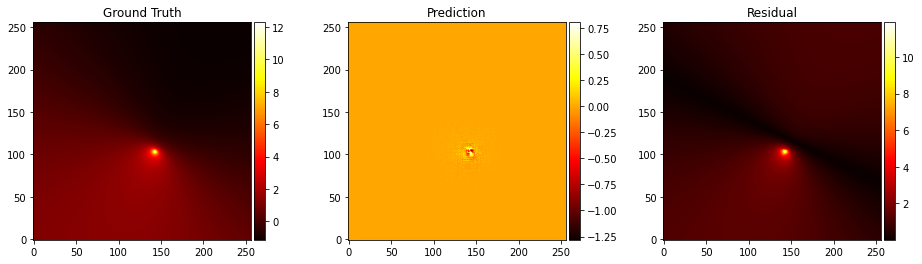

In [57]:
ind = 20
dim = 0


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
im = ax1.imshow(alp.numpy()[ind, ..., dim], cmap="hot", origin="lower")
divider = make_axes_locatable(ax1)
cax    = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(im,cax=cax)   
ax1.set_title("Ground Truth")

im = ax2.imshow(alpha_pred.numpy()[ind, ..., dim], cmap="hot", origin="lower")
divider = make_axes_locatable(ax2)
cax    = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(im,cax=cax)   
ax2.set_title("Prediction")


residual = np.abs(alpha_pred.numpy()[ind, ..., dim] - alp.numpy()[ind, ..., dim])
im = ax3.imshow(residual, cmap="hot", origin="lower")
divider = make_axes_locatable(ax3)
cax    = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(im,cax=cax)
ax3.set_title("Residual")

pass

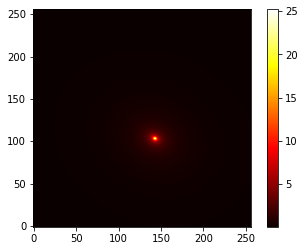

In [58]:
plt.imshow(kap.numpy()[ind, ..., 0], cmap="hot", origin="lower")
plt.colorbar()
pass